### Importing Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# load the data

df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

In [6]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [5]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


### Data Cleaning

In [7]:
# add a target class column to indicate whether the news is real or fake

df_true['isfake'] = 1
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  isfake  
0  December 31, 2017        1  
1  December 29, 2017        1  
2  December 31, 2017        1  
3  December 30, 2017        1  
4  December 29, 2017        1

In [8]:
df_fake['isfake'] = 0
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  isfake  
0  December 31, 2017       0  
1  December 31, 2017       0  
2  December 30, 2017       0  
3  December 29, 2017       0  
4  December 25, 2017       0

In [9]:
# Concatenate Real and Fake News

df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isfake  
0      December 31, 2017        1  
1      December 29, 2017        1  
2      December 31, 2017        1  
3      December 30, 2017        1  
4      December 29, 2017        1  
...                   ...     ...  
44893    January 16, 2016       0  
44894    January 16, 2016       0  
44895    January 15, 2016       0  
44896    January 14, 2016       0  
44897    January 12, 2016       0  

[44898 rows x 5 columns]

In [10]:
df.drop(columns = ['date'], inplace = True)
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  isfake  
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews       1  
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews       1  
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews       1  
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews       1  
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews       1

In [11]:
# combine title and text together

df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  isfake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews       1   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews       1   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews       1   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews       1   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews       1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

In [12]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [13]:
# Obtain additional stopwords from nltk

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [15]:
# Remove stopwords and remove words with 2 or less characters

def preprocess(text):
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [16]:
# Apply the function to the dataframe

df['clean'] = df['original'].apply(preprocess)

In [17]:
# Show original news

df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [18]:
# Show cleaned up news after removing stopwords

print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [19]:
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  isfake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews       1   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews       1   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews       1   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews       1   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews       1   

                                            original  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                               clean  
0  [budget, fight, looms, republicans, flip, fisc...  
1  [military, accept, transgender, recruits, mond...  
2  [senior, republican, senator, mueller, washing...  
3  [russia, probe, helped, australian, diplomat, ...  
4  [trump, wants, postal, service, charge, amazon...

In [20]:
# Obtain the total words present in the dataset

list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)


In [21]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [22]:
len(list_of_words)

9276947

In [23]:
# Obtain the total number of unique words

total_words = len(list(set(list_of_words)))
total_words

108704

In [24]:
# join the words into a string

df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [25]:
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  isfake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews       1   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews       1   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews       1   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews       1   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews       1   

                                            original  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                               clean  \
0  [budget, fight, looms, republicans, flip, fisc...   
1  [military, accept, transgender, recruits, mond...   
2  [senior, republican, senator, mueller, washing...   
3  [russia, probe, helped, australian, diplomat, ...   
4  [trump, wants, postal, service, charge, amazon...   

                                        clean_joined  
0  budget fight looms republicans flip fiscal scr...  
1  military accept transgender recruits monday pe...  
2  senior republican senator mueller washington r...  
3  russia probe helped australian diplomat washin...  
4  trump wants postal service charge amazon shipm...

### Explolatory Data Analysis

In [37]:
sns.set(style="ticks", context="notebook")
plt.style.use("dark_background")

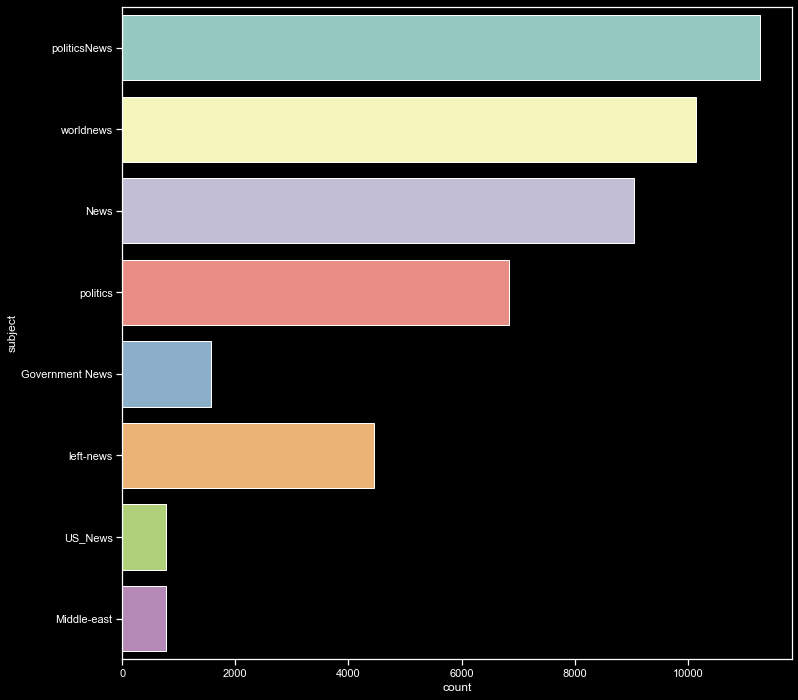

In [39]:
# plot the number of samples in 'subject'

plt.figure(figsize = (12, 12))
sns.countplot(y = "subject", data = df);

<AxesSubplot:xlabel='count', ylabel='isfake'>

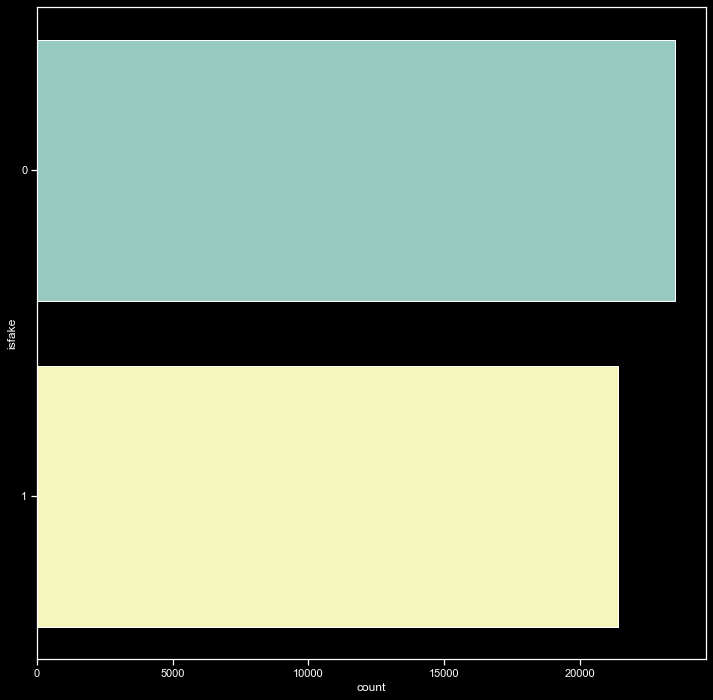

In [40]:
# plot the number of samples per each class

plt.figure(figsize = (12, 12))
sns.countplot(y = "isfake", data = df)

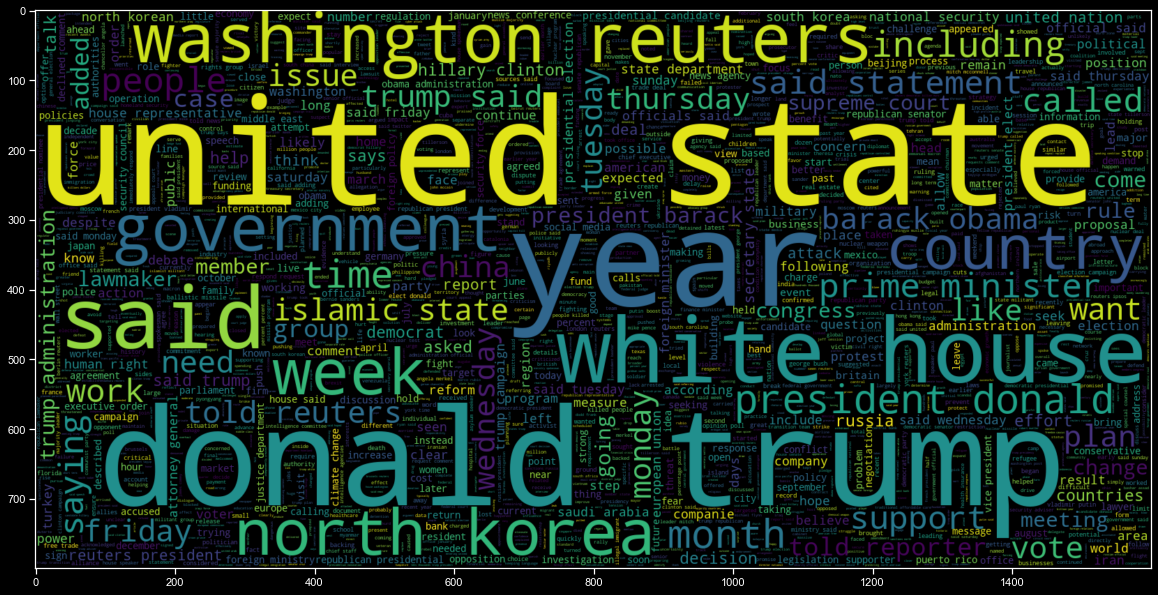

In [42]:
# plot the word cloud for Real News

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear');

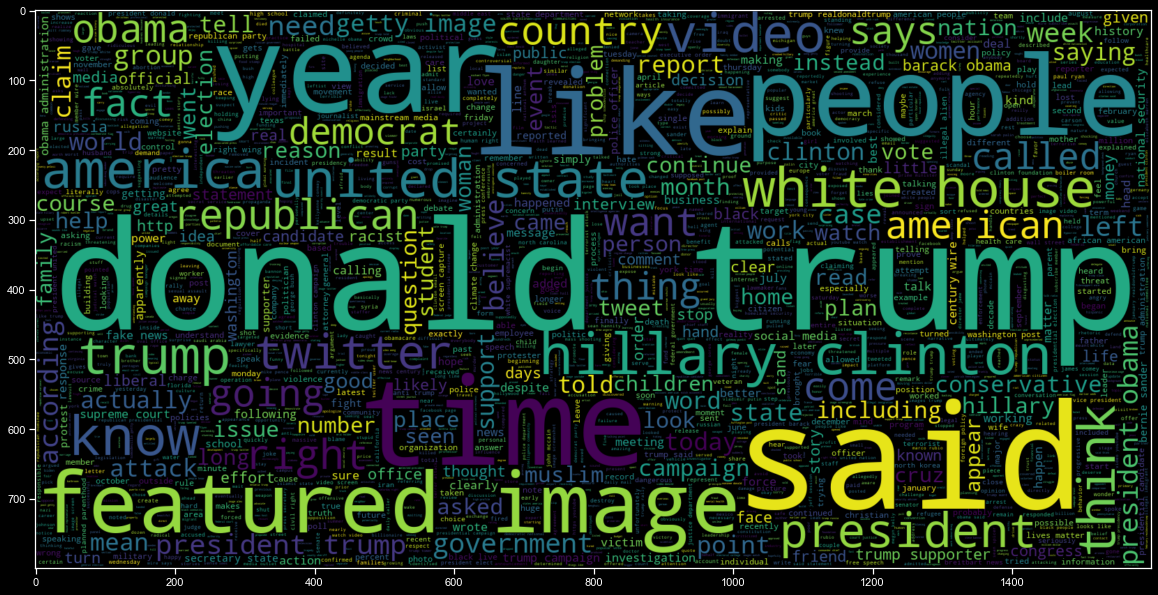

In [43]:
# plot the word cloud for Fake News

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [44]:
# Calculate length of maximum document to create word embeddings 

maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
        
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [45]:
import plotly.express as px

In [46]:
# visualize the distribution of number of words in a text

fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

### Data Preprocessing by Tokenization and Padding

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
# split data into test and train 

x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [77]:
from nltk import word_tokenize

In [52]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [53]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [54]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results

padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [55]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [  71 2347  868  135  243 5060 1306  243   25    9   16   12   71  437
   79  868  176 1149 1393  135 1906   71 5060 1306    3   10    1  207
   31  452  758 1285  207 1593 1816   25 1105 2884   22 7769]
The padded encoding for document 2  is :  [   8   38  447    1   84 1202   25    9    8  448   13  139  109  973
  420   93  447    3   10    1   84   15    8   13 1202    2  114  150
 1202   17    9   79  354   38  267 6700  412  274   51    0]


### Building and Training the Model

In [56]:
# Sequential Model

model = Sequential()

# embeddidng layer

model.add(Embedding(total_words, output_dim = 128))


# Bi-Directional RNN and LSTM

model.add(Bidirectional(LSTM(128)))

# Dense layers

model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         13914112  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 14,210,305
Trainable params: 14,210,305
Non-trainable params: 0
_________________________________________________________________


In [57]:
total_words

108704

In [58]:
y_train = np.asarray(y_train)

In [59]:
y_train

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [60]:
# train the model

model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 151s 280ms/step - loss: 0.1378 - acc: 0.9290 - val_loss: 0.0068 - val_acc: 0.9992
Epoch 2/2
506/506 [==============================] - 150s 297ms/step - loss: 0.0026 - acc: 0.9995 - val_loss: 0.0064 - val_acc: 0.9986


### Assess the Model Perfomance

In [63]:
# make predictions 

pred = model.predict(padded_test)

In [64]:
# if the predicted value is >0.5 it is real else it is fake

prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [67]:
# Check the accuracy

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Test Accuracy : ", accuracy)

Model Test Accuracy :  0.9961024498886414


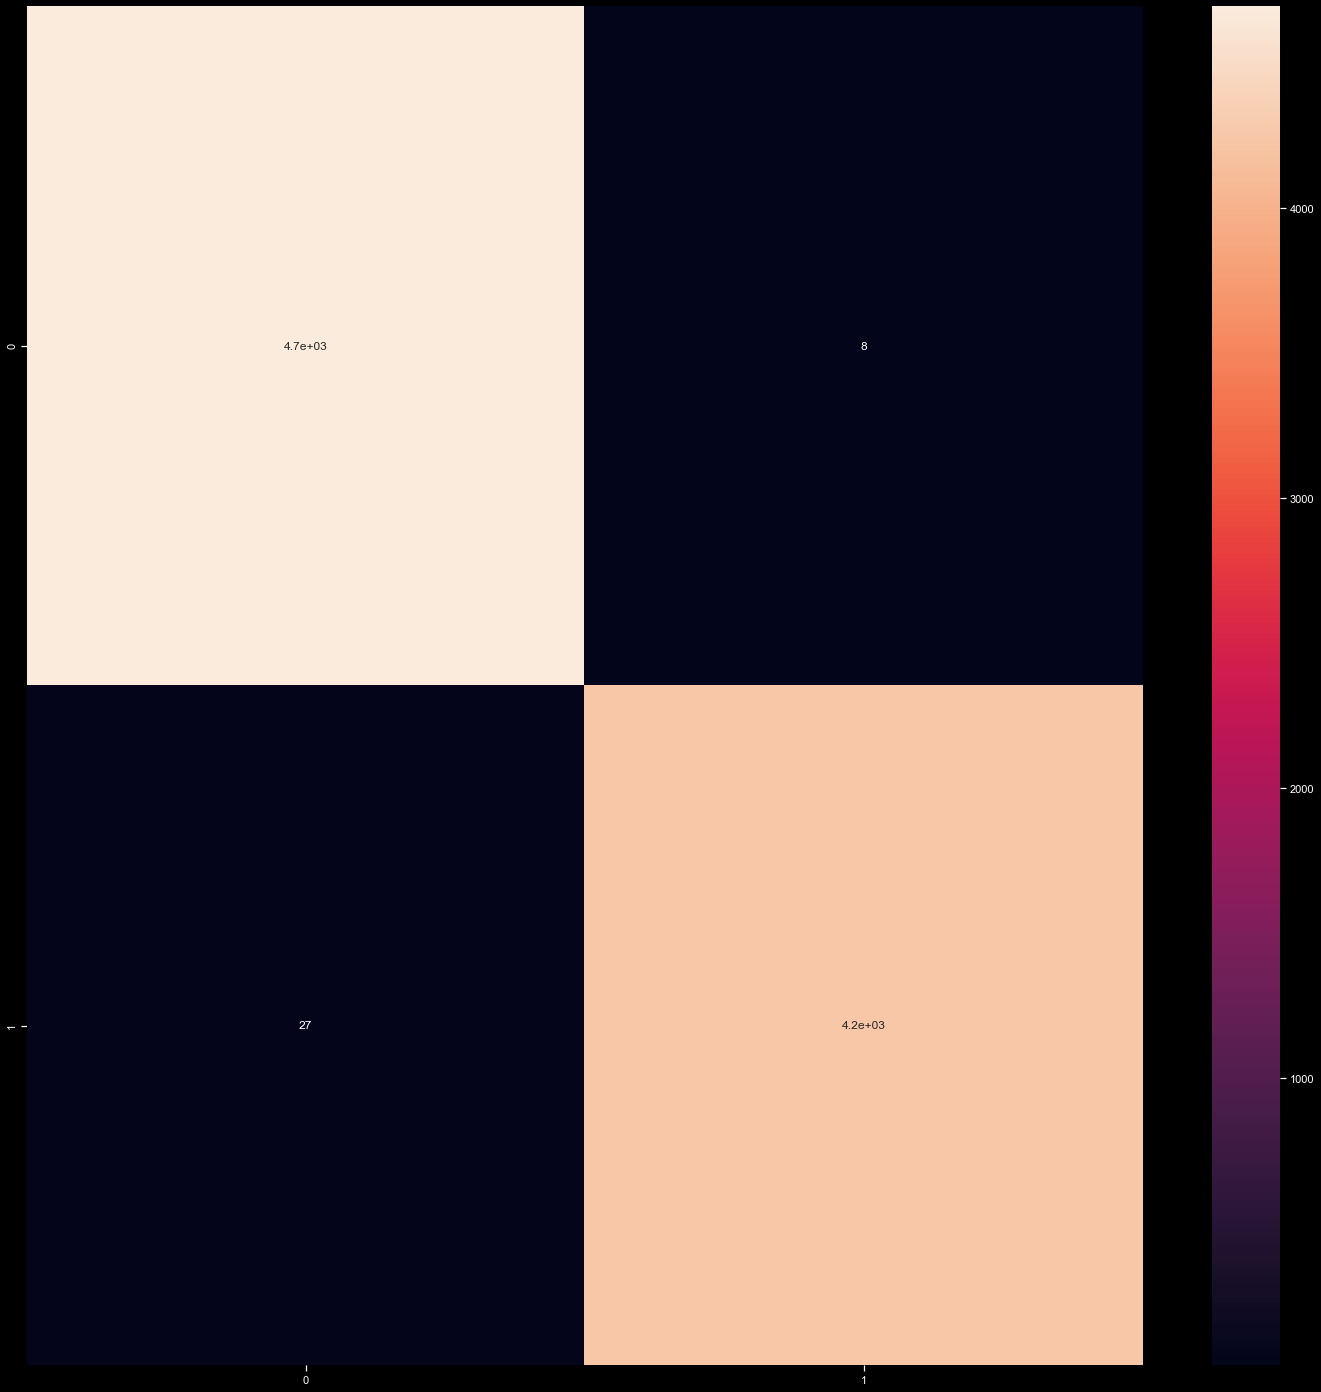

In [71]:
# The Confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True);